In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as stats
from sklearn.feature_selection import chi2, f_classif
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.rcParams['figure.figsize'] = (12, 6)

print("🔍 COMPREHENSIVE EXPLORATORY DATA ANALYSIS")
print("🎯 Goal: Understand data for asthma prediction modeling")
print("=" * 70)

🔍 COMPREHENSIVE EXPLORATORY DATA ANALYSIS
🎯 Goal: Understand data for asthma prediction modeling


In [2]:
# =============================================================================
# 1. DATA LOADING AND INITIAL OVERVIEW
# =============================================================================

# Load both original and processed data for comparison
df_original = pd.read_csv('../../data/raw/asthma_disease_data.csv')
df_processed = pd.read_csv('../../data/processed/asthma_data_processed.csv')

print(f"📊 DATASET OVERVIEW")
print(f"Original dataset: {df_original.shape}")
print(f"Processed dataset: {df_processed.shape}")

# Use processed data for main analysis
df = df_processed.copy()

print(f"\n📋 Dataset Information:")
print(f"   Samples: {df.shape[0]:,}")
print(f"   Features: {df.shape[1]}")
print(f"   Memory usage: {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

# Quick data quality check
missing_values = df.isnull().sum().sum()
duplicates = df.duplicated().sum()

print(f"\n🔍 Data Quality:")
print(f"   Missing values: {missing_values}")
print(f"   Duplicate rows: {duplicates}")
print(f"   Data completeness: {((df.shape[0] * df.shape[1] - missing_values) / (df.shape[0] * df.shape[1]) * 100):.1f}%")


📊 DATASET OVERVIEW
Original dataset: (2392, 29)
Processed dataset: (2392, 32)

📋 Dataset Information:
   Samples: 2,392
   Features: 32
   Memory usage: 0.49 MB

🔍 Data Quality:
   Missing values: 0
   Duplicate rows: 0
   Data completeness: 100.0%



🎯 TARGET VARIABLE ANALYSIS
Target variable: Diagnosis

📊 Target Distribution:
   0 (No Asthma): 2,268 samples (94.8%)
   1 (Has Asthma): 124 samples (5.2%)

⚖️  Class Balance Analysis:
   Majority class: 94.8%
   Minority class: 5.2%
   Imbalance ratio: 18.29:1
   ⚠️  Dataset is imbalanced - consider sampling strategies


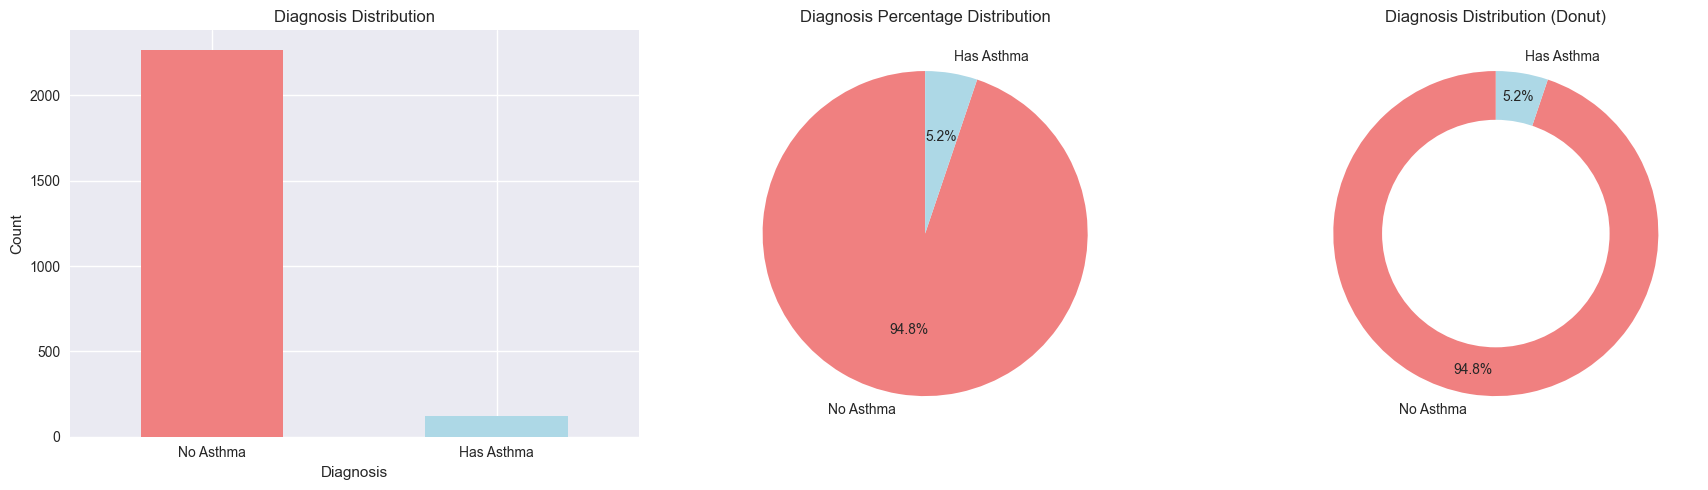

In [3]:
# =============================================================================
# 2. TARGET VARIABLE ANALYSIS
# =============================================================================

print(f"\n" + "="*70)
print(f"🎯 TARGET VARIABLE ANALYSIS")
print("="*70)

TARGET_COLUMN = 'Diagnosis'
print(f"Target variable: {TARGET_COLUMN}")

# Target distribution
target_dist = df[TARGET_COLUMN].value_counts().sort_index()
target_pct = df[TARGET_COLUMN].value_counts(normalize=True).sort_index() * 100

print(f"\n📊 Target Distribution:")
for value, count in target_dist.items():
    percentage = target_pct[value]
    label = "No Asthma" if value == 0 else "Has Asthma"
    print(f"   {value} ({label}): {count:,} samples ({percentage:.1f}%)")

# Calculate class imbalance
minority_class_pct = min(target_pct.values)
majority_class_pct = max(target_pct.values)
imbalance_ratio = majority_class_pct / minority_class_pct

print(f"\n⚖️  Class Balance Analysis:")
print(f"   Majority class: {majority_class_pct:.1f}%")
print(f"   Minority class: {minority_class_pct:.1f}%")
print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 2:
    print(f"   ⚠️  Dataset is imbalanced - consider sampling strategies")
else:
    print(f"   ✅ Dataset is reasonably balanced")

# Visualize target distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Bar plot
target_dist.plot(kind='bar', ax=axes[0], color=['lightcoral', 'lightblue'])
axes[0].set_title(f'{TARGET_COLUMN} Distribution')
axes[0].set_xlabel('Diagnosis')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No Asthma', 'Has Asthma'], rotation=0)

# Pie chart
axes[1].pie(target_dist.values, labels=['No Asthma', 'Has Asthma'], autopct='%1.1f%%', 
           colors=['lightcoral', 'lightblue'], startangle=90)
axes[1].set_title(f'{TARGET_COLUMN} Percentage Distribution')

# Donut chart for better visualization
wedges, texts, autotexts = axes[2].pie(target_dist.values, labels=['No Asthma', 'Has Asthma'], 
                                      autopct='%1.1f%%', colors=['lightcoral', 'lightblue'],
                                      startangle=90, pctdistance=0.85)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
axes[2].add_artist(centre_circle)
axes[2].set_title(f'{TARGET_COLUMN} Distribution (Donut)')

plt.tight_layout()
plt.show()

In [4]:
# =============================================================================
# 3. FEATURE CATEGORIZATION AND ANALYSIS
# =============================================================================

print(f"\n" + "="*70)
print(f"📊 FEATURE CATEGORIZATION")
print("="*70)

# Categorize features by type and medical domain
DEMOGRAPHIC_FEATURES = ['PatientID', 'Age', 'Gender', 'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 
                       'EducationLevel_1', 'EducationLevel_2', 'EducationLevel_3']
LIFESTYLE_FEATURES = ['BMI', 'Smoking', 'PhysicalActivity', 'DietQuality', 'SleepQuality']
ENVIRONMENTAL_FEATURES = ['PollutionExposure', 'PollenExposure', 'DustExposure']
MEDICAL_HISTORY_FEATURES = ['PetAllergy', 'FamilyHistoryAsthma', 'HistoryOfAllergies', 'Eczema', 
                           'HayFever', 'GastroesophagealReflux']
LUNG_FUNCTION_FEATURES = ['LungFunctionFEV1', 'LungFunctionFVC']
SYMPTOM_FEATURES = ['Wheezing', 'ShortnessOfBreath', 'ChestTightness', 'Coughing', 
                   'NighttimeSymptoms', 'ExerciseInduced']

print(f"📋 Feature Categories:")
print(f"   Demographics ({len(DEMOGRAPHIC_FEATURES)}): {DEMOGRAPHIC_FEATURES[:3]}...")
print(f"   Lifestyle ({len(LIFESTYLE_FEATURES)}): {LIFESTYLE_FEATURES}")
print(f"   Environmental ({len(ENVIRONMENTAL_FEATURES)}): {ENVIRONMENTAL_FEATURES}")
print(f"   Medical History ({len(MEDICAL_HISTORY_FEATURES)}): {MEDICAL_HISTORY_FEATURES[:3]}...")
print(f"   Lung Function ({len(LUNG_FUNCTION_FEATURES)}): {LUNG_FUNCTION_FEATURES}")
print(f"   Symptoms ({len(SYMPTOM_FEATURES)}): {SYMPTOM_FEATURES[:3]}...")

# Identify numerical vs categorical features
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET_COLUMN in numerical_features:
    numerical_features.remove(TARGET_COLUMN)
if 'PatientID' in numerical_features:
    numerical_features.remove('PatientID')

categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
binary_features = [col for col in df.columns if df[col].nunique() == 2 and col != TARGET_COLUMN]

print(f"\n📊 Data Type Analysis:")
print(f"   Numerical features: {len(numerical_features)}")
print(f"   Categorical features: {len(categorical_features)}")
print(f"   Binary features: {len(binary_features)}")


📊 FEATURE CATEGORIZATION
📋 Feature Categories:
   Demographics (9): ['PatientID', 'Age', 'Gender']...
   Lifestyle (5): ['BMI', 'Smoking', 'PhysicalActivity', 'DietQuality', 'SleepQuality']
   Environmental (3): ['PollutionExposure', 'PollenExposure', 'DustExposure']
   Medical History (6): ['PetAllergy', 'FamilyHistoryAsthma', 'HistoryOfAllergies']...
   Lung Function (2): ['LungFunctionFEV1', 'LungFunctionFVC']
   Symptoms (6): ['Wheezing', 'ShortnessOfBreath', 'ChestTightness']...

📊 Data Type Analysis:
   Numerical features: 24
   Categorical features: 0
   Binary features: 20



📈 NUMERICAL FEATURES ANALYSIS
📊 Descriptive Statistics:


,Age,Gender,BMI,Smoking,PhysicalActivity,DietQuality,SleepQuality,PollutionExposure,PollenExposure,DustExposure,PetAllergy,FamilyHistoryAsthma,HistoryOfAllergies,Eczema,HayFever,GastroesophagealReflux,LungFunctionFEV1,LungFunctionFVC,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced
count,2392.000,2392.000,2392.000,2392.000,2392.000,2392.000,2392.000,2392.000,2392.000,2392.000,2392.000,2392.000,2392.000,2392.000,2392.000,2392.000,2392.000,2392.000,2392.000,2392.0,2392.000,2392.000,2392.000,2392.000
mean,0.000,0.493,0.000,0.142,0.000,-0.000,-0.000,0.000,0.000,0.000,0.166,0.301,0.399,0.192,0.253,0.158,0.000,-0.000,0.596,0.5,0.503,0.503,0.602,0.605
std,1.000,0.500,1.000,0.349,1.000,1.000,1.000,1.000,1.000,1.000,0.372,0.459,0.490,0.394,0.435,0.365,1.000,1.000,0.491,0.5,0.500,0.500,0.489,0.489
min,-1.719,0.000,-1.696,0.000,-1.740,-1.725,-1.742,-1.708,-1.768,-1.742,0.000,0.000,0.000,0.000,0.000,0.000,-1.797,-1.720,0.000,0.0,0.000,0.000,0.000,0.000
25%,-0.886,0.000,-0.872,0.000,-0.852,-0.891,-0.878,-0.879,-0.869,-0.880,0.000,0.000,0.000,0.000,0.000,0.000,-0.841,-0.870,0.000,0.0,0.000,0.000,0.000,0.000
50%,-0.006,0.000,-0.027,0.000,-0.012,0.032,-0.025,0.008,-0.005,-0.027,0.000,0.000,0.000,0.000,0.000,0.000,0.005,-0.005,1.000,1.0,1.000,1.000,1.000,1.000
75%,0.873,1.000,0.877,0.000,0.857,0.867,0.871,0.892,0.897,0.857,0.000,1.000,1.000,0.000,1.000,0.000,0.864,0.861,1.000,1.0,1.000,1.000,1.000,1.000
max,1.706,1.000,1.770,1.000,1.703,1.711,1.719,1.699,1.689,1.755,1.000,1.000,1.000,1.000,1.000,1.000,1.684,1.732,1.000,1.0,1.000,1.000,1.000,1.000


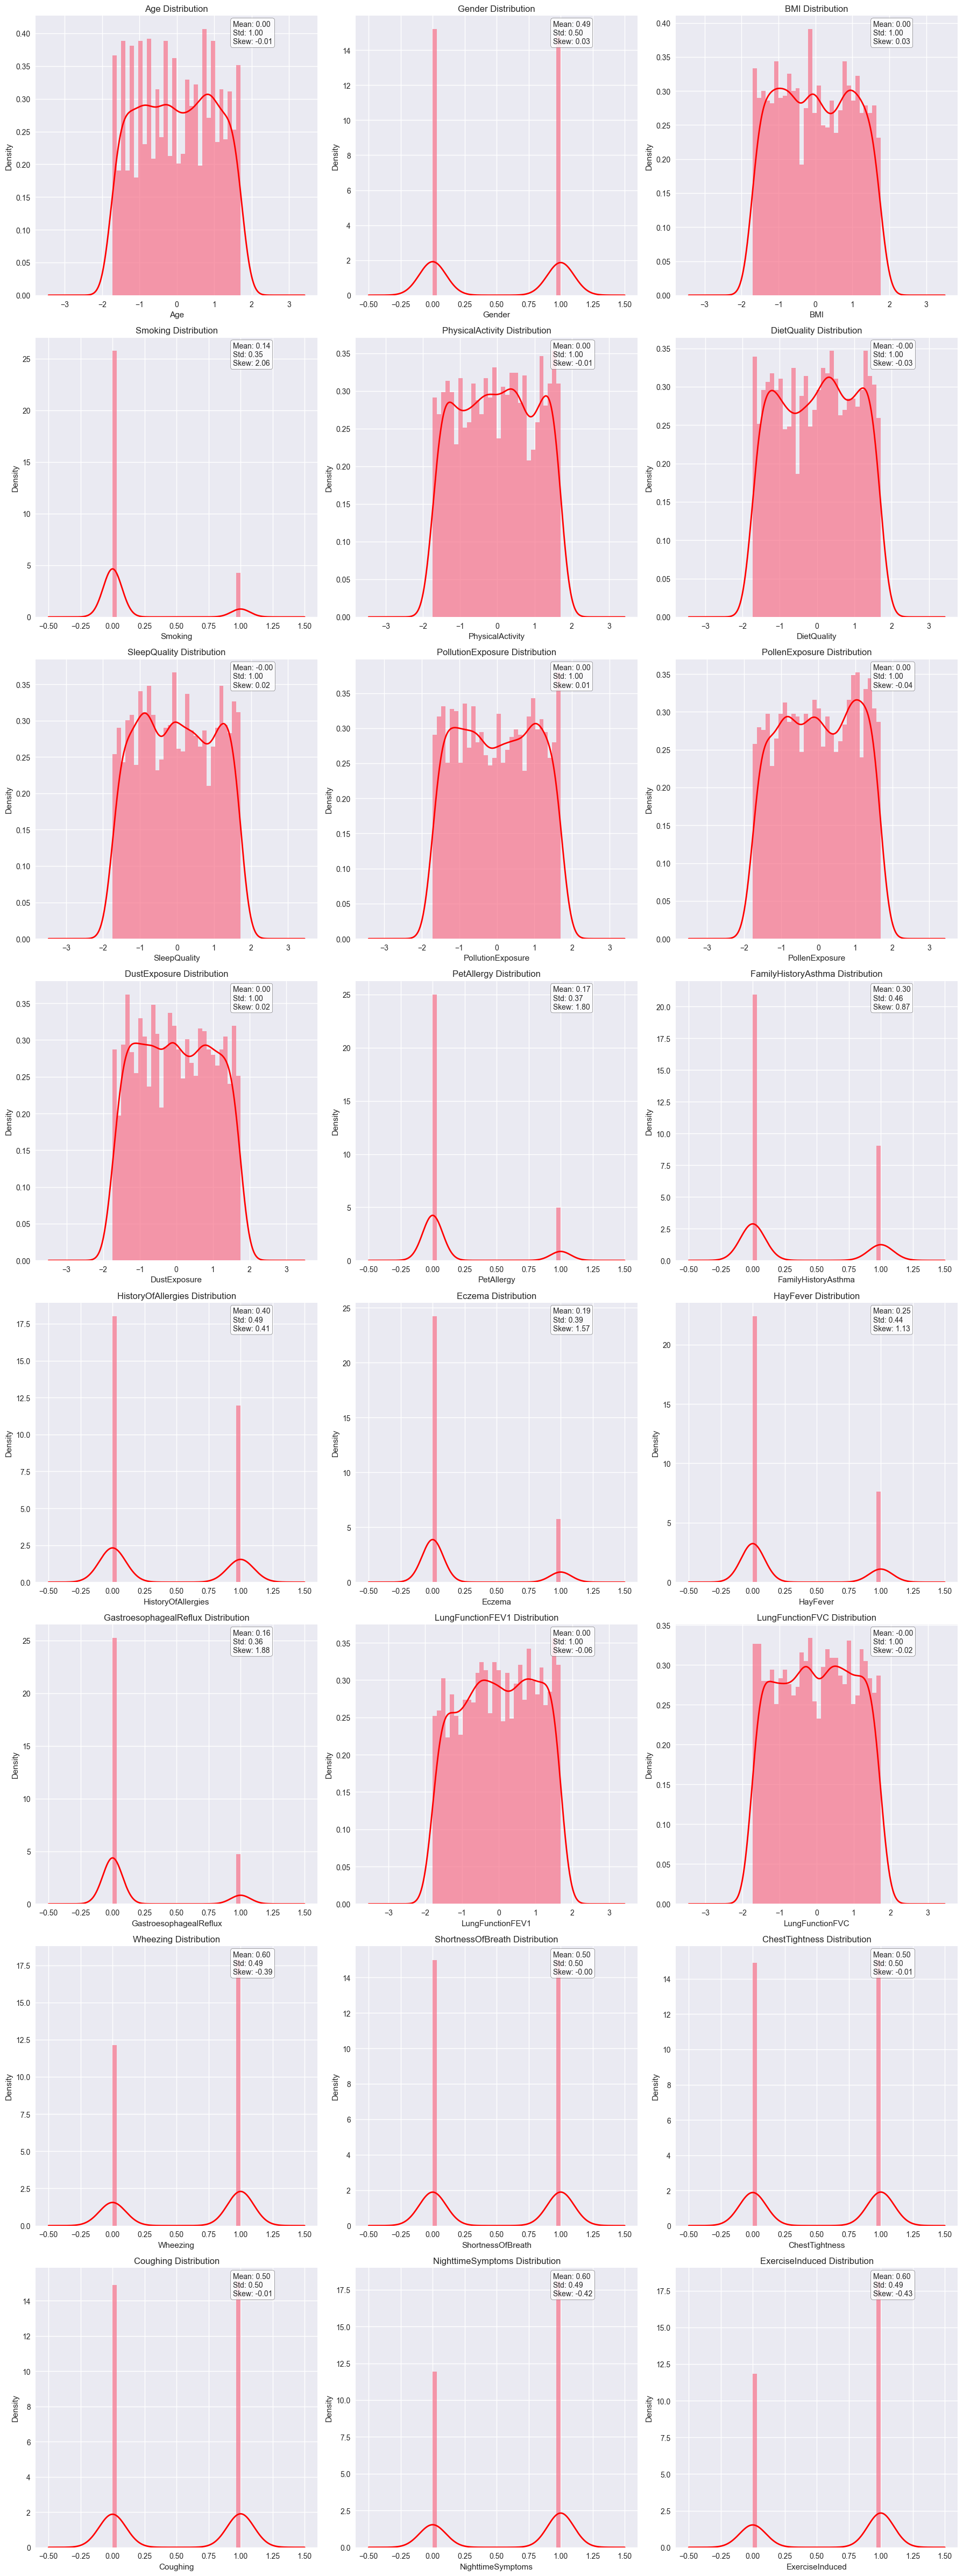


📐 Skewness Analysis:
   Age: -0.012 (Nearly symmetric, left)
   Gender: 0.027 (Nearly symmetric, right)
   BMI: 0.027 (Nearly symmetric, right)
   Smoking: 2.056 (Highly skewed, right)
   PhysicalActivity: -0.010 (Nearly symmetric, left)
   DietQuality: -0.033 (Nearly symmetric, left)
   SleepQuality: 0.018 (Nearly symmetric, right)
   PollutionExposure: 0.005 (Nearly symmetric, right)
   PollenExposure: -0.041 (Nearly symmetric, left)
   DustExposure: 0.016 (Nearly symmetric, right)
   PetAllergy: 1.797 (Highly skewed, right)
   FamilyHistoryAsthma: 0.868 (Moderately skewed, right)
   HistoryOfAllergies: 0.412 (Nearly symmetric, right)
   Eczema: 1.566 (Highly skewed, right)
   HayFever: 1.135 (Highly skewed, right)
   GastroesophagealReflux: 1.876 (Highly skewed, right)
   LungFunctionFEV1: -0.059 (Nearly symmetric, left)
   LungFunctionFVC: -0.015 (Nearly symmetric, left)
   Wheezing: -0.392 (Nearly symmetric, left)
   ShortnessOfBreath: -0.002 (Nearly symmetric, left)
   ChestTigh

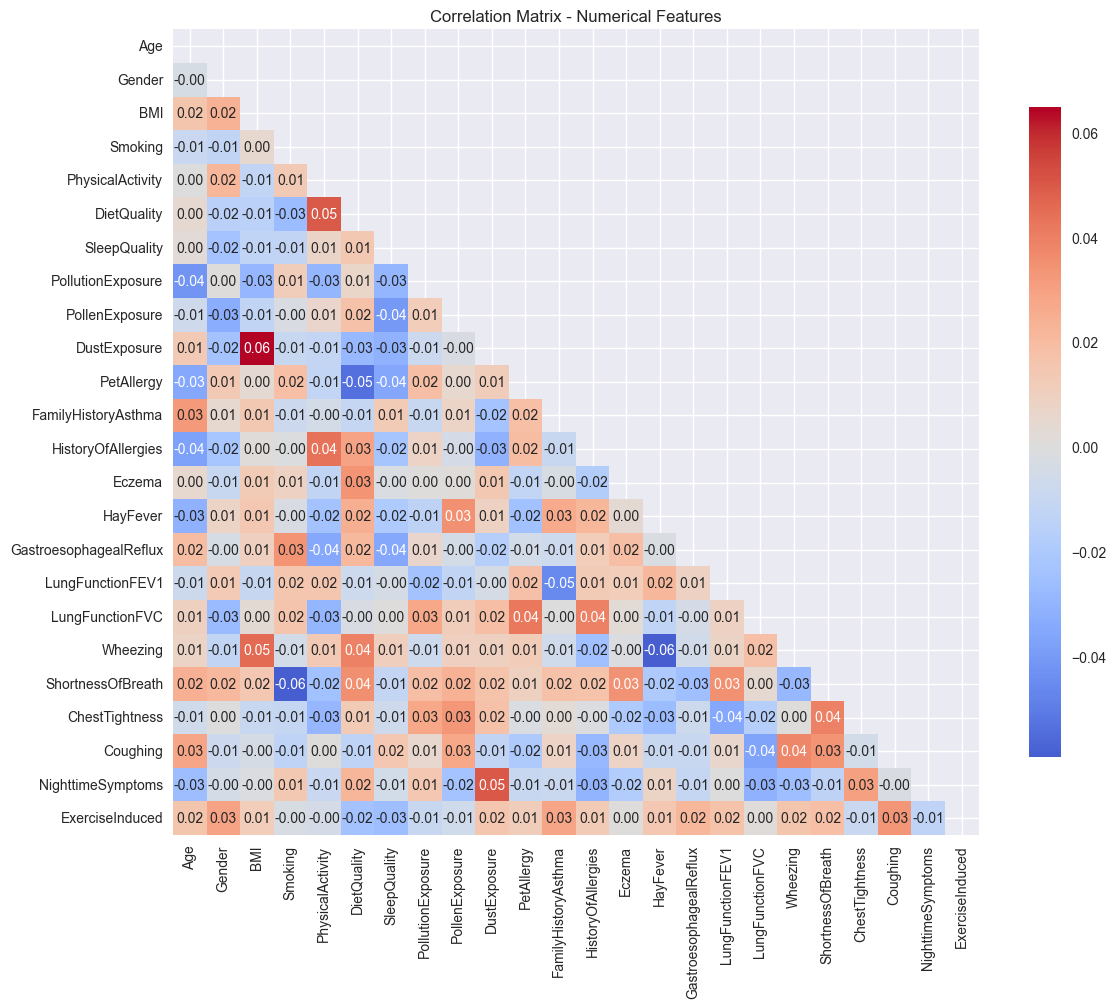


✅ No highly correlated features found


In [5]:
# =============================================================================
# 4. NUMERICAL FEATURES ANALYSIS
# =============================================================================

print(f"\n" + "="*70)
print(f"📈 NUMERICAL FEATURES ANALYSIS")
print("="*70)

# Descriptive statistics
print(f"📊 Descriptive Statistics:")
numerical_stats = df[numerical_features].describe()
display(numerical_stats.round(3))

# Distribution analysis with subplots
n_numerical = len(numerical_features)
if n_numerical > 0:
    # Create distribution plots
    n_cols = 3
    n_rows = (n_numerical + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for i, col in enumerate(numerical_features):
        if i < len(axes):
            # Histogram with KDE
            df[col].hist(bins=30, alpha=0.7, ax=axes[i], density=True)
            df[col].plot.kde(ax=axes[i], secondary_y=False, color='red', linewidth=2)
            axes[i].set_title(f'{col} Distribution')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Density')
            
            # Add statistics text
            mean_val = df[col].mean()
            std_val = df[col].std()
            skew_val = df[col].skew()
            axes[i].text(0.7, 0.9, f'Mean: {mean_val:.2f}\nStd: {std_val:.2f}\nSkew: {skew_val:.2f}',
                        transform=axes[i].transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Hide empty subplots
    for i in range(n_numerical, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

    # Identify skewed distributions
    print(f"\n📐 Skewness Analysis:")
    skewness_data = []
    for col in numerical_features:
        skew_val = df[col].skew()
        skewness_data.append({'Feature': col, 'Skewness': skew_val})
        
        if abs(skew_val) > 1:
            skew_type = "Highly skewed"
        elif abs(skew_val) > 0.5:
            skew_type = "Moderately skewed"
        else:
            skew_type = "Nearly symmetric"
            
        direction = "right" if skew_val > 0 else "left" if skew_val < 0 else "symmetric"
        print(f"   {col}: {skew_val:.3f} ({skew_type}, {direction})")
    
    skewness_df = pd.DataFrame(skewness_data).sort_values('Skewness', key=abs, ascending=False)
    
    # Correlation matrix for numerical features
    if len(numerical_features) > 1:
        print(f"\n🔗 Correlation Analysis:")
        correlation_matrix = df[numerical_features].corr()
        
        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                   square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
        plt.title('Correlation Matrix - Numerical Features')
        plt.tight_layout()
        plt.show()
        
        # Find highly correlated pairs
        high_corr_pairs = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i+1, len(correlation_matrix.columns)):
                corr_val = correlation_matrix.iloc[i, j]
                if abs(corr_val) > 0.7:
                    high_corr_pairs.append((correlation_matrix.columns[i], 
                                          correlation_matrix.columns[j], corr_val))
        
        if high_corr_pairs:
            print(f"\n⚠️  High Correlations (|r| > 0.7):")
            for var1, var2, corr in high_corr_pairs:
                print(f"   {var1} ↔ {var2}: {corr:.3f}")
        else:
            print(f"\n✅ No highly correlated features found")



📝 CATEGORICAL/BINARY FEATURES ANALYSIS
📊 Analyzing 20 categorical/binary features


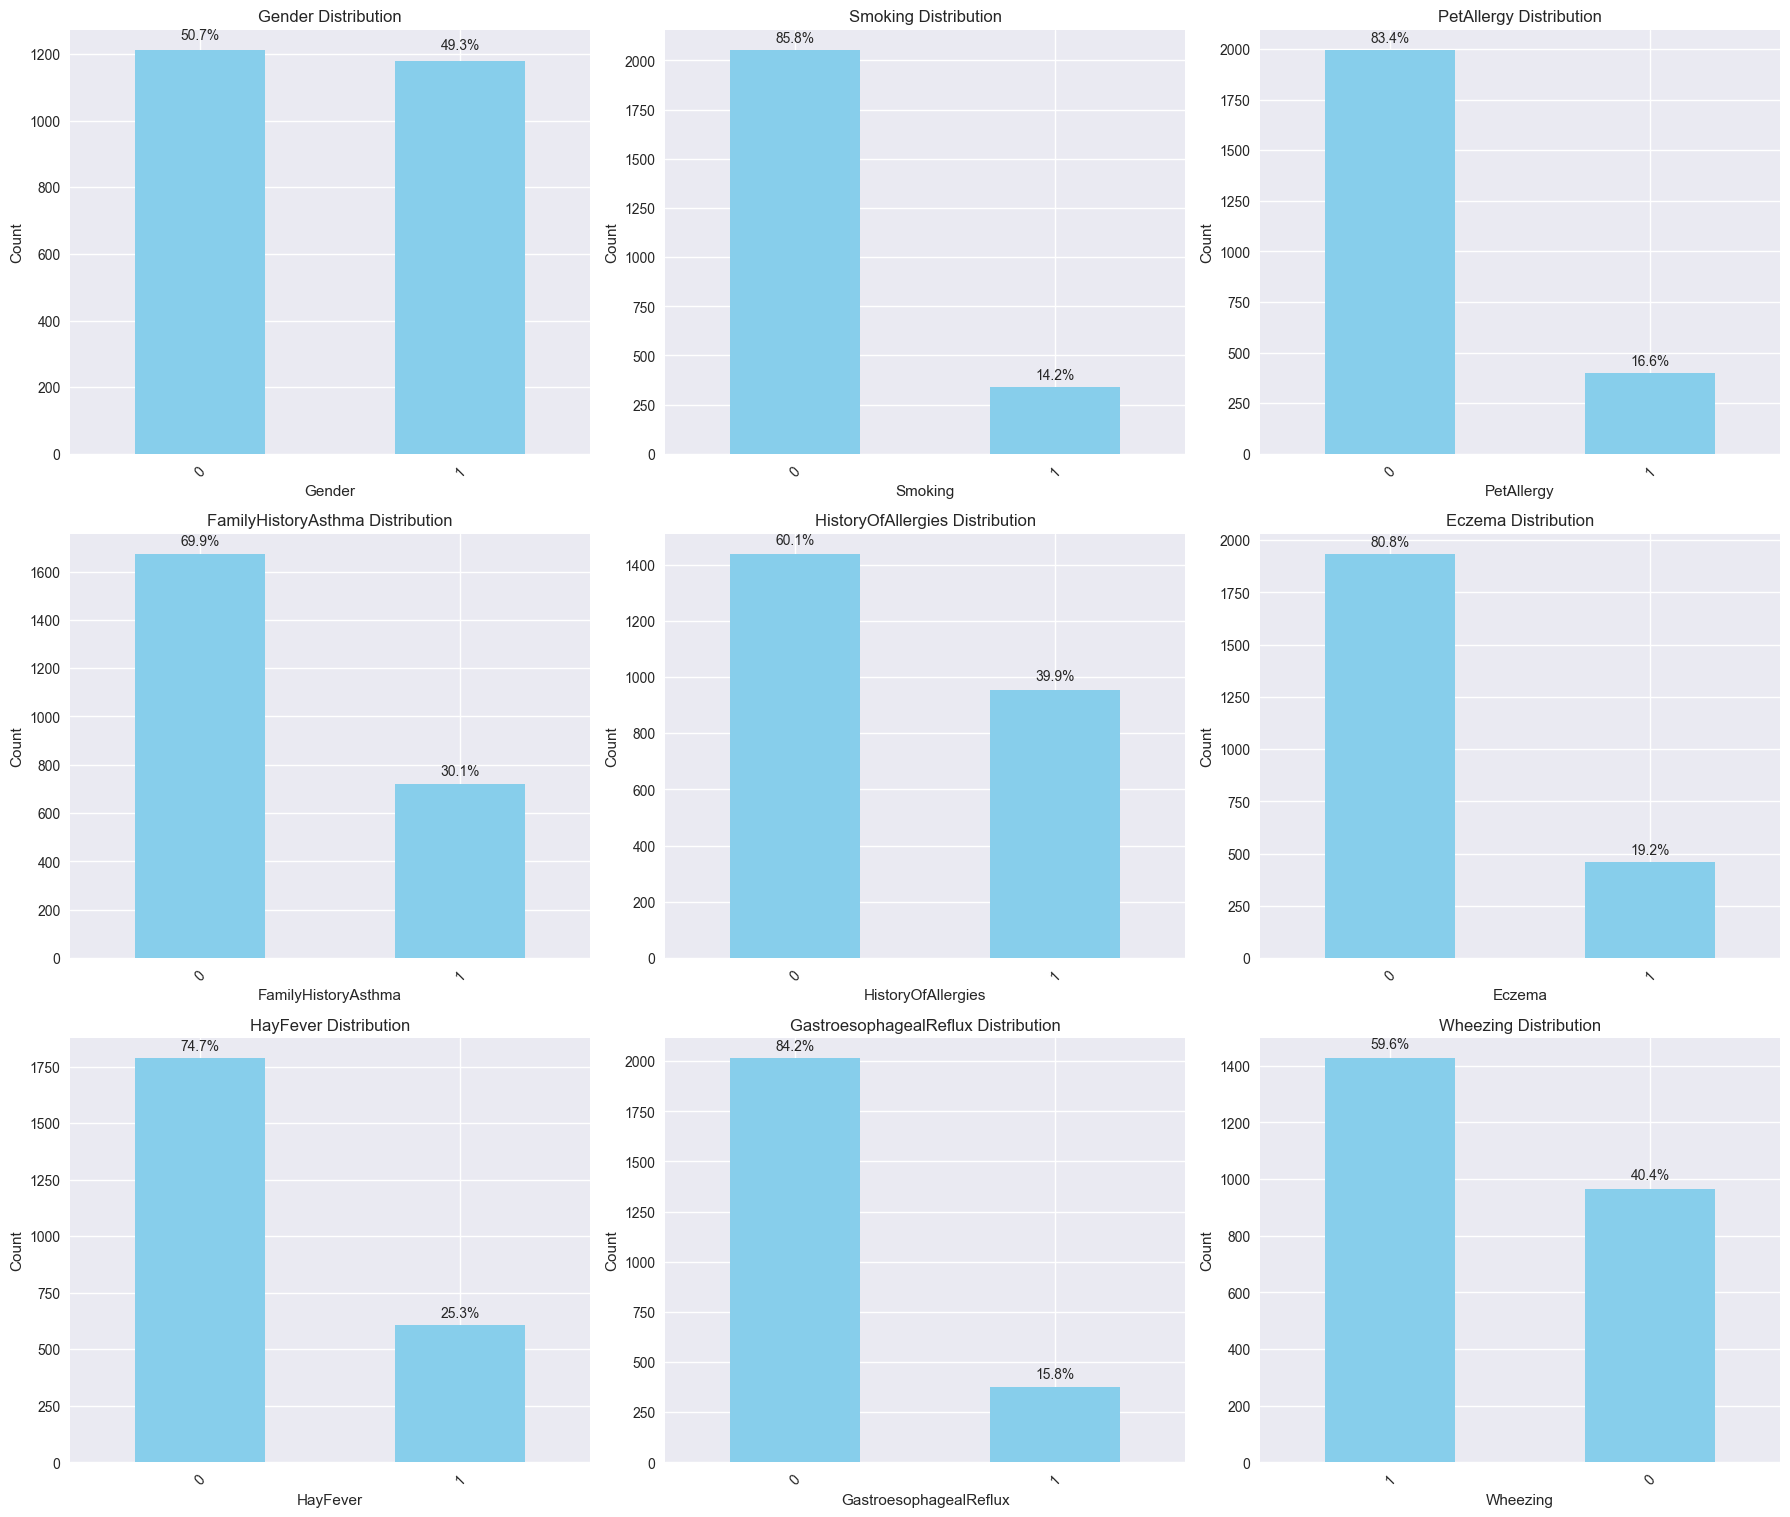

In [6]:
# =============================================================================
# 5. CATEGORICAL/BINARY FEATURES ANALYSIS
# =============================================================================

print(f"\n" + "="*70)
print(f"📝 CATEGORICAL/BINARY FEATURES ANALYSIS")
print("="*70)

all_categorical = binary_features + categorical_features

if all_categorical:
    print(f"📊 Analyzing {len(all_categorical)} categorical/binary features")
    
    # Create visualization for categorical features
    n_cats = len(all_categorical)
    n_cols = 3
    n_rows = (n_cats + n_cols - 1) // n_cols
    
    if n_cats > 0:
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        axes = axes.flatten()
        
        for i, col in enumerate(all_categorical[:9]):  # Limit to first 9
            if i < len(axes):
                value_counts = df[col].value_counts()
                value_counts.plot(kind='bar', ax=axes[i], color='skyblue')
                axes[i].set_title(f'{col} Distribution')
                axes[i].set_xlabel(col)
                axes[i].set_ylabel('Count')
                axes[i].tick_params(axis='x', rotation=45)
                
                # Add percentage labels
                total = value_counts.sum()
                for j, (val, count) in enumerate(value_counts.items()):
                    pct = count / total * 100
                    axes[i].text(j, count + total*0.01, f'{pct:.1f}%', 
                               ha='center', va='bottom')
        
        # Hide empty subplots
        for i in range(min(n_cats, 9), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()

In [7]:
# =============================================================================
# 6. TARGET vs FEATURES BIVARIATE ANALYSIS
# =============================================================================

print(f"\n" + "="*70)
print(f"🎯 BIVARIATE ANALYSIS: FEATURES vs TARGET")
print("="*70)

print(f"🔍 Analyzing relationships between features and {TARGET_COLUMN}")

# Numerical features vs target
if numerical_features:
    print(f"\n📊 Numerical Features vs Target:")
    
    # Statistical tests for numerical features
    numerical_stats = []
    for col in numerical_features[:6]:  # Limit for space
        # Group by target
        group_0 = df[df[TARGET_COLUMN] == 0][col]
        group_1 = df[df[TARGET_COLUMN] == 1][col]
        
        # T-test
        t_stat, p_value = stats.ttest_ind(group_0, group_1)
        
        # Effect size (Cohen's d)
        pooled_std = np.sqrt(((len(group_0) - 1) * group_0.var() + 
                             (len(group_1) - 1) * group_1.var()) / 
                            (len(group_0) + len(group_1) - 2))
        cohens_d = (group_1.mean() - group_0.mean()) / pooled_std
        
        numerical_stats.append({
            'Feature': col,
            'No_Asthma_Mean': group_0.mean(),
            'Has_Asthma_Mean': group_1.mean(),
            'T_Statistic': t_stat,
            'P_Value': p_value,
            'Cohens_D': cohens_d,
            'Significant': p_value < 0.05
        })
    
    stats_df = pd.DataFrame(numerical_stats)
    stats_df = stats_df.sort_values('P_Value')
    
    print(f"\n📈 Statistical Test Results (Top Features):")
    display(stats_df[['Feature', 'No_Asthma_Mean', 'Has_Asthma_Mean', 'P_Value', 'Cohens_D', 'Significant']].round(4))
    
    # Visualize top significant features
    significant_features = stats_df[stats_df['Significant']]['Feature'].tolist()[:4]
    
    if significant_features:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for i, col in enumerate(significant_features):
            # Box plot
            df.boxplot(column=col, by=TARGET_COLUMN, ax=axes[i])
            axes[i].set_title(f'{col} by Diagnosis')
            axes[i].set_xlabel('Diagnosis (0=No Asthma, 1=Has Asthma)')
            axes[i].set_ylabel(col)
            
        plt.suptitle('Significant Numerical Features by Diagnosis', y=1.02)
        plt.tight_layout()
        plt.show()

# Categorical features vs target
if all_categorical:
    print(f"\n📝 Categorical Features vs Target:")
    
    categorical_stats = []
    for col in all_categorical[:8]:  # Limit for space
        # Contingency table
        contingency = pd.crosstab(df[col], df[TARGET_COLUMN])
        
        # Chi-square test
        chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency)
        
        # Cramér's V (effect size for categorical)
        n = contingency.sum().sum()
        cramers_v = np.sqrt(chi2_stat / (n * (min(contingency.shape) - 1)))
        
        categorical_stats.append({
            'Feature': col,
            'Chi2_Statistic': chi2_stat,
            'P_Value': p_value,
            'Cramers_V': cramers_v,
            'Significant': p_value < 0.05
        })
    
    cat_stats_df = pd.DataFrame(categorical_stats)
    cat_stats_df = cat_stats_df.sort_values('P_Value')
    
    print(f"\n📊 Chi-Square Test Results:")
    display(cat_stats_df[['Feature', 'Chi2_Statistic', 'P_Value', 'Cramers_V', 'Significant']].round(4))
    
    # Visualize most significant categorical features
    significant_categorical = cat_stats_df[cat_stats_df['Significant']]['Feature'].tolist()[:4]
    
    if significant_categorical:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for i, col in enumerate(significant_categorical):
            # Stacked bar chart
            crosstab = pd.crosstab(df[col], df[TARGET_COLUMN], normalize='index') * 100
            crosstab.plot(kind='bar', stacked=True, ax=axes[i], 
                         color=['lightcoral', 'lightblue'])
            axes[i].set_title(f'{col} vs Diagnosis (%)')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Percentage')
            axes[i].legend(['No Asthma', 'Has Asthma'])
            axes[i].tick_params(axis='x', rotation=45)
        
        plt.suptitle('Significant Categorical Features vs Diagnosis', y=1.02)
        plt.tight_layout()
        plt.show()



🎯 BIVARIATE ANALYSIS: FEATURES vs TARGET
🔍 Analyzing relationships between features and Diagnosis

📊 Numerical Features vs Target:

📈 Statistical Test Results (Top Features):


,Feature,No_Asthma_Mean,Has_Asthma_Mean,P_Value,Cohens_D,Significant
3,Smoking,0.1433,0.1129,0.3449,-0.0871,False
0,Age,0.0035,-0.0646,0.4601,-0.0681,False
2,BMI,0.0029,-0.0536,0.5404,-0.0565,False
4,PhysicalActivity,-0.0012,0.0217,0.8044,0.0228,False
5,DietQuality,0.0007,-0.0135,0.8777,-0.0142,False
1,Gender,0.4929,0.5000,0.8785,0.0141,False



📝 Categorical Features vs Target:

📊 Chi-Square Test Results:


,Feature,Chi2_Statistic,P_Value,Cramers_V,Significant
7,GastroesophagealReflux,0.9746,0.3235,0.0202,False
6,HayFever,0.6891,0.4065,0.0170,False
1,Smoking,0.6606,0.4164,0.0166,False
2,PetAllergy,0.2659,0.6061,0.0105,False
5,Eczema,0.0919,0.7618,0.0062,False
0,Gender,0.0037,0.9515,0.0012,False
4,HistoryOfAllergies,0.0000,0.9990,0.0000,False
3,FamilyHistoryAsthma,0.0000,1.0000,0.0000,False



🏆 FEATURE IMPORTANCE ANALYSIS
📊 Feature importance analysis using statistical methods:
   Features: 30
   Samples: 2392

📈 Top 10 Features by F-Score:


,Feature,F_Score,P_Value,Significant
23,ExerciseInduced,6.978320,0.008304,True
29,EducationLevel_3,4.727611,0.029780,True
28,EducationLevel_2,3.822427,0.050687,False
20,ChestTightness,3.692989,0.054760,False
17,LungFunctionFVC,2.099965,0.147434,False
18,Wheezing,1.769168,0.183612,False
9,DustExposure,1.613295,0.204153,False
21,Coughing,1.399657,0.236899,False
16,LungFunctionFEV1,1.302200,0.253926,False
15,GastroesophagealReflux,1.239820,0.265618,False


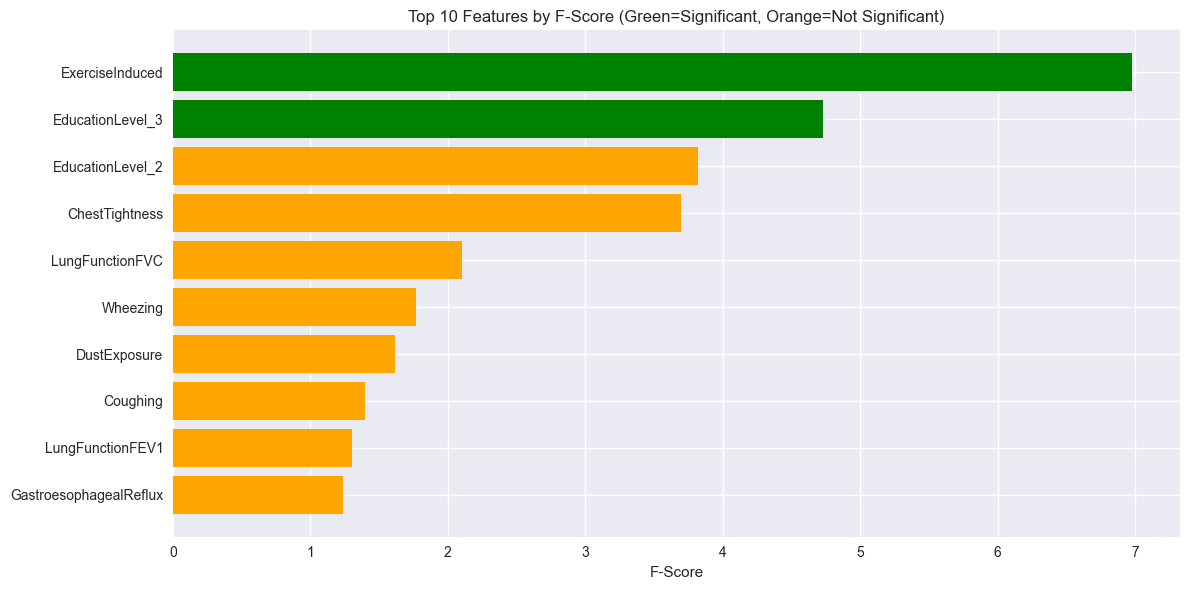

In [8]:
# =============================================================================
# 7. FEATURE IMPORTANCE ANALYSIS
# =============================================================================

print(f"\n" + "="*70)
print(f"🏆 FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Prepare data for feature importance
X = df.drop([TARGET_COLUMN, 'PatientID'], axis=1)
y = df[TARGET_COLUMN]

print(f"📊 Feature importance analysis using statistical methods:")
print(f"   Features: {X.shape[1]}")
print(f"   Samples: {X.shape[0]}")

# For numerical features - ANOVA F-test
numerical_mask = X.dtypes != 'object'
if numerical_mask.any():
    X_numerical = X.loc[:, numerical_mask]
    f_scores, f_pvalues = f_classif(X_numerical, y)
    
    f_importance = pd.DataFrame({
        'Feature': X_numerical.columns,
        'F_Score': f_scores,
        'P_Value': f_pvalues,
        'Significant': f_pvalues < 0.05
    }).sort_values('F_Score', ascending=False)
    
    print(f"\n📈 Top 10 Features by F-Score:")
    display(f_importance.head(10))
    
    # Visualize top features
    top_features = f_importance.head(10)
    
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(top_features)), top_features['F_Score'], 
             color=['green' if sig else 'orange' for sig in top_features['Significant']])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('F-Score')
    plt.title('Top 10 Features by F-Score (Green=Significant, Orange=Not Significant)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()